# **Settings**

In [2]:
# 패키지 설치
!pip install langchain_google_genai faiss-cpu langchain_community langchain_openai sentence-transformers

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# 라이브러리 불러오기
import os
import sys
from langchain_community.document_loaders.csv_loader import CSVLoader
from pathlib import Path
from langchain_openai import ChatOpenAI,OpenAIEmbeddings
import os
from dotenv import load_dotenv
load_dotenv()
from langchain.document_loaders import CSVLoader
from langchain.text_splitter import TextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.prompts import PromptTemplate
import faiss
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
import pickle
import ast
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from tqdm import tqdm
from collections import defaultdict
import re
from joblib import Parallel, delayed

## **임베딩과 벡터 불러오기**

In [4]:
# 임베당과 벡터스토어 불러오기
from langchain.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
new_vectorstore = FAISS.load_local("vectorstore_index_contextual_nonoverlapping", embeddings, allow_dangerous_deserialization=True)
new_vectorstore

/tmp/ipykernel_368240/3212302991.py:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
/home/rlaalsduf/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-19 15:51:16.190081: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn the

## **데이터 불러오기**

In [8]:
# 그래프임베딩이 포함된 데이테프레임 불러오기
# 그래프임베딩이 포함된 데이테프레임 불러오기
import pandas as pd
import numpy as np

data = pd.read_csv("header_vanila.csv")
data.head()
# data['graph_embedding'] = np.array(data['graph_embedding'].apply(eval))

,UserId,avg_var_text,count_text,chunk_header
0,1,"Drama(4.43), Comedy(4.14), Sci-Fi(4.33), Roman...","Drama(21), Comedy(14), Sci-Fi(3), Romance(6), ...",This user tends to favor genres that are emoti...
1,2,"Action(3.5), Adventure(3.74), Romance(3.71), S...","Action(56), Adventure(19), Romance(24), Sci-Fi...","This user tends to favor intense, high-stakes ..."
2,3,"Drama(4.0), Thriller(3.8), Comedy(3.77), Actio...","Drama(8), Thriller(5), Comedy(30), Action(23),...",This user tends to favor emotional and family-...
3,4,"Action(4.16), Adventure(3.83), Romance(4.0), S...","Action(19), Adventure(6), Romance(2), Sci-Fi(9...","This user tends to favor high-energy, action-p..."
4,5,"Comedy(3.41), Horror(2.8), Drama(3.1), Thrille...","Comedy(56), Horror(10), Drama(104), Thriller(3...",This user tends to favor heartwarming and fami...


In [9]:
# data['chunk_header']의 모든 텍스트를 리스트로 변환
texts = data['chunk_header'].tolist()

# 텍스트 리스트를 임베딩
embeddings_array = embeddings.embed_documents(texts)  # 결과는 List[List[float]] 형태
data['chunk_header_embedding'] = embeddings_array

In [10]:
df_train = pd.read_csv('data/train_movie.csv')
df_train.head()

,UserId,movie_explain
0,1,"['3186 (Drama) ratings: 4', '1270 (Comedy|Sci-..."
1,2,"['1198 (Action|Adventure) ratings: 4', '1210 (..."
2,3,"['593 (Drama|Thriller) ratings: 3', '2858 (Com..."
3,4,['1210 (Action|Adventure|Romance|Sci-Fi|War) r...
4,5,"['2717 (Comedy|Horror) ratings: 1', '908 (Dram..."


In [11]:
data = data.merge(df_train[['UserId', 'movie_explain']], on='UserId', how='left')
data.head()

,UserId,avg_var_text,count_text,chunk_header,chunk_header_embedding,movie_explain
0,1,"Drama(4.43), Comedy(4.14), Sci-Fi(4.33), Roman...","Drama(21), Comedy(14), Sci-Fi(3), Romance(6), ...",This user tends to favor genres that are emoti...,"[0.031729161739349365, -0.11494535207748413, 0...","['3186 (Drama) ratings: 4', '1270 (Comedy|Sci-..."
1,2,"Action(3.5), Adventure(3.74), Romance(3.71), S...","Action(56), Adventure(19), Romance(24), Sci-Fi...","This user tends to favor intense, high-stakes ...","[0.049116265028715134, -0.12668681144714355, -...","['1198 (Action|Adventure) ratings: 4', '1210 (..."
2,3,"Drama(4.0), Thriller(3.8), Comedy(3.77), Actio...","Drama(8), Thriller(5), Comedy(30), Action(23),...",This user tends to favor emotional and family-...,"[0.04370708391070366, -0.10269396752119064, -0...","['593 (Drama|Thriller) ratings: 3', '2858 (Com..."
3,4,"Action(4.16), Adventure(3.83), Romance(4.0), S...","Action(19), Adventure(6), Romance(2), Sci-Fi(9...","This user tends to favor high-energy, action-p...","[0.01632581651210785, -0.10685384273529053, 0....",['1210 (Action|Adventure|Romance|Sci-Fi|War) r...
4,5,"Comedy(3.41), Horror(2.8), Drama(3.1), Thrille...","Comedy(56), Horror(10), Drama(104), Thriller(3...",This user tends to favor heartwarming and fami...,"[0.01539221964776516, -0.09879115223884583, 0....","['2717 (Comedy|Horror) ratings: 1', '908 (Dram..."


In [12]:
data.iloc[:, 1:].to_csv('./data/user_with_chunk_embeddings', index=False)

## **그래프 임베딩 사용**

In [13]:
import numpy as np

# 텍스트 임베딩을 헤더로 사용
def create_header_embeddings_dict(data):
    header_embeddings_dict = {}

    for _, row in data.iterrows():
        user_id = str(row["UserId"])
        graph_embedding = np.array(row["chunk_header_embedding"])

        # UserId를 키로 저장
        header_embeddings_dict[user_id] = graph_embedding

    return header_embeddings_dict

# UserId별 그래프 임베딩 벡터 매핑 생성
header_embeddings_dict = create_header_embeddings_dict(data)

In [14]:
import numpy as np
import faiss
import pandas as pd
from tqdm import tqdm

# UserId와 그래프 임베딩 리스트로 변환
user_ids = list(header_embeddings_dict.keys())
text_embeddings = np.array(list(header_embeddings_dict.values())).astype(np.float32)

# FAISS 인덱스 생성
dimension = text_embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)

# 벡터DB에 그래프 임베딩 추가
faiss_index.add(text_embeddings)
user_ids = data["UserId"].tolist()

# **RAPTOR 트리 구축**

## **차원축소**

In [15]:
!pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 KB 1.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 31.1 MB/s eta 0:00:0000:0100:01


In [16]:
!pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Defaulting to user installation because normal site-packages is not writeable


In [17]:
import umap

# 임베딩 추출
def extract_embeddings(vectorstore):
    num_vectors = vectorstore.ntotal  # 벡터 개수
    dimension = vectorstore.d  # 벡터 차원
    embeddings = np.zeros((num_vectors, dimension), dtype=np.float32)

    # FAISS 벡터 추출
    for i in range(num_vectors):
        embeddings[i] = vectorstore.reconstruct(i)

    return embeddings

# umap을 사용한 차원 축소
def apply_umap(embeddings, target_dim=10, n_neighbors=30, min_dist=0.1):
    """400차원 벡터를 UMAP으로 10차원으로 차원 축소"""
    print(f"UMAP 실행 중... (입력 차원: {embeddings.shape[1]}, 목표 차원: {target_dim})")

    reducer = umap.UMAP(
        n_components=target_dim,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="euclidean",
        random_state=42
    )

    embeddings_reduced = reducer.fit_transform(embeddings)

    return embeddings_reduced

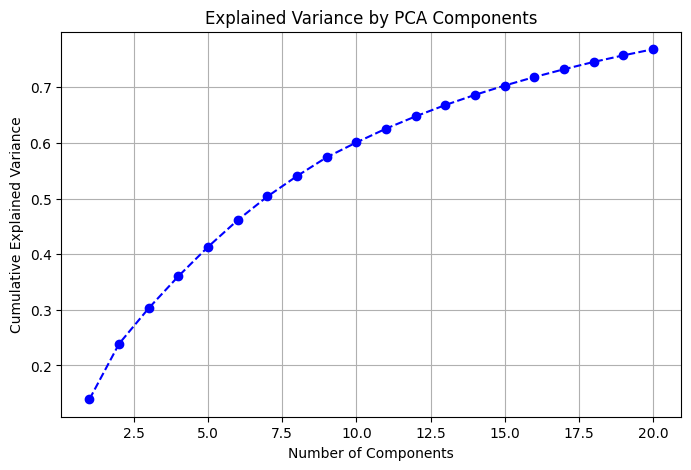

In [18]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# PCA를 활용한 분산 설명률 계산 (20차원까지)
pca = PCA(n_components=20)
pca.fit(text_embeddings)

# 분산 설명률 출력
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# 시각화
plt.figure(figsize=(8, 5))
plt.plot(range(1, 21), cumulative_variance, marker="o", linestyle="--", color="b")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid()
plt.show()

## **GMM 클러스터링**

## **RAPTOR 트리 생성**

In [20]:
import numpy as np
import pandas as pd
import logging
from tqdm import tqdm
from sklearn.mixture import GaussianMixture

# 클러스터 매핑 딕셔너리
cluster_mapping = {}

# GMM 클러스터링
def perform_clustering(embeddings: np.ndarray, n_clusters: int = 10) -> np.ndarray:
    gm = GaussianMixture(n_components=n_clusters, random_state=42)
    return gm.fit_predict(embeddings)

# 그래프 임베딩을 이용해 RAPTOR TREE 만들기
def build_raptor_tree(text_embeddings: np.ndarray, user_ids: list, max_levels: int = 3, n_clusters: int = 20):

    results = {}  # 각 층별로 결과 저장
    current_vectors = text_embeddings.copy()
    current_user_ids = user_ids.copy()  # 초기 사용자 ID
    current_metadata = [{"level": 0, "origin": "original", "parent_id": None} for _ in range(len(user_ids))]

    for level in range(1, max_levels + 1):

        # 클러스터 개수 설정
        n_clusters = min(n_clusters, len(current_vectors) // 8)

        # GMM 기반 클러스터링 수행
        cluster_labels = perform_clustering(current_vectors, n_clusters)

        # 현재 층에서의 데이터 저장
        df = pd.DataFrame({
            'user_id': current_user_ids,
            'embedding': list(current_vectors),
            'cluster': cluster_labels,
            'metadata': current_metadata
        })
        results[level - 1] = df

        new_vectors = []
        new_user_ids = []
        new_metadata = []

        # 클러스터별 그룹화
        for cluster in tqdm(df['cluster'].unique(), desc=f"🔍 Level {level} - Clustering"):
            cluster_docs = df[df['cluster'] == cluster]
            cluster_vectors = np.array(cluster_docs['embedding'].tolist())
            cluster_metadata = cluster_docs['metadata'].tolist()

            # 클러스터 중심 벡터 계산 (평균으로 계산)
            cluster_center = np.mean(cluster_vectors, axis=0)
            new_vectors.append(cluster_center)

            # 새로운 상위 노드 ID (요약)
            cluster_id = f"cluster_{level}_{cluster}"
            new_user_ids.append(cluster_id)

            # 하위 노드 수집
            child_ids = cluster_docs['user_id'].tolist()

            # 클러스터 매핑 저장
            cluster_mapping[cluster_id] = child_ids

            # 새로운 메타데이터 추가
            new_metadata.append({
                "level": level,
                "origin": f"summary_of_cluster_{cluster}_level_{level - 1}",
                "child_ids": child_ids,
                "id": cluster_id
            })

        # 다음 레벨 데이터 업데이트
        current_vectors = np.array(new_vectors)
        current_user_ids = new_user_ids
        current_metadata = new_metadata

        # 클러스터링할 데이터가 1개 이하일 경우 종료
        if len(current_vectors) <= 1:
            results[level] = pd.DataFrame({
                'user_id': current_user_ids,
                'embedding': list(current_vectors),
                'cluster': [0],
                'metadata': current_metadata
            })
            break

    return results, cluster_mapping



In [21]:
# 사용자ID
user_ids = data["UserId"].tolist()

# RAPTOR 트리 구축 / 클러스터 정보
raptor_tree, cluster_mapping = build_raptor_tree(text_embeddings, user_ids, max_levels=3, n_clusters=256)

# 결과 확인
print("RAPTOR Tree Level 0:")
print(raptor_tree[0].head())

🔍 Level 3 - Clustering: 100%|██████████| 4/4 [00:00<00:00, 606.68it/s]

RAPTOR Tree Level 0:
   user_id                                          embedding  cluster  \
0        1  [0.03172916, -0.11494535, 0.03968509, 0.028569...       67   
1        2  [0.049116265, -0.12668681, -0.0042271875, -0.0...      203   
2        3  [0.043707084, -0.10269397, -0.002848608, 0.019...       24   
3        4  [0.016325817, -0.10685384, 0.018458545, 0.0384...      204   
4        5  [0.01539222, -0.09879115, 0.0133083025, -0.001...      109   

                                            metadata  
0  {'level': 0, 'origin': 'original', 'parent_id'...  
1  {'level': 0, 'origin': 'original', 'parent_id'...  
2  {'level': 0, 'origin': 'original', 'parent_id'...  
3  {'level': 0, 'origin': 'original', 'parent_id'...  
4  {'level': 0, 'origin': 'original', 'parent_id'...  


## **저장**

In [25]:
import json

# 클러스터 매핑을 JSON 파일로 변환
def save_cluster_mapping(cluster_mapping, filename="./data/cluster_mapping_header.json"):
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(cluster_mapping, f, indent=4, ensure_ascii=False)

# 클러스터 매핑 저장
save_cluster_mapping(cluster_mapping)

In [24]:
import pickle

# RAPTOR 트리 저장
with open("./data/text_header_raptor_tree.pkl", "wb") as f:
    pickle.dump(raptor_tree, f)
print("RAPTOR 트리 저장 완료: raptor_tree.pkl")

RAPTOR 트리 저장 완료: raptor_tree.pkl


In [ ]:
# RAPTOR 벡터DB 저장
def build_vectorstore_from_tree(tree: dict) -> faiss.IndexFlatL2:
    all_embeddings = []
    for level, df in tree.items():
        all_embeddings.extend(df['embedding'].tolist())
    all_embeddings = np.stack(all_embeddings, axis=0).astype('float32')
    dimension = all_embeddings.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(all_embeddings)
    return index

faiss_vectorstore_1 = build_vectorstore_from_tree(raptor_tree)
faiss.write_index(faiss_vectorstore, "raptor_graph_embeddings_faiss_db.index")